# Intel Image Classififcation SVM (Support Vector Machine)

### 1. Imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random as rn
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
import seaborn as sn;sn.set(font_scale=1.4)

### 2. Paths

In [9]:
CURR_DIR_PATH = os.getcwd()

# Training paths
seg_train_path = CURR_DIR_PATH + "//data//seg_train//seg_train"

train_forest_path = seg_train_path + "//forest"
train_buildings_path = seg_train_path + "//buildings"
train_glacier_path = seg_train_path + "//glacier"
train_mountain_path = seg_train_path + "//mountain"
train_sea_path = seg_train_path + "//sea"
train_street_path = seg_train_path + "//street"

# Test paths
seg_test_path = CURR_DIR_PATH + "//data//seg_test//seg_test"

test_forest_path = seg_test_path + "//forest"
test_buildings_path = seg_test_path + "//buildings"
test_glacier_path = seg_test_path + "//glacier"
test_mountain_path = seg_test_path + "//mountain"
test_sea_path = seg_test_path + "//sea"
test_street_path = seg_test_path + "//street"

# Prediction path

seg_pred_path = CURR_DIR_PATH + "//data//seg_pred//seg_pred"

# Our path

seg_our_path = CURR_DIR_PATH + "//data//seg_our//seg_our"

### 3. Load and transform images

 3.1 Defining train and test variables

In [10]:
# Training variables
X_train =[]
label_train = []
# Test variables
X_test = [] 
label_test = []
# Category labels (classes)
category_label=['buildings','forest', 'glacier','mountain','sea','street']

3.2 Extract the image data using cv2 and feature.hog modules (hog=Histogram oriented gradients)

In [11]:
def extract_image_data(image_path):
    image = cv2.imread(image_path)
    image=cv2.resize(image,(150,150)) 
    image= feature.hog(image, channel_axis=-1)/255.0    # set channel_axis=-1 to manage pictures with colors
    return image

3.3 Load images from path and stores features in X_train and X_test

In [12]:
def image_to_array (category_type, image_path, data_type):
    category_path = os.path.join(image_path,category_type.lower())
    print('Loading ' + data_type +' images for category type '+ category_type)
    for image in os.listdir(category_path):
        image_path = os.path.join(category_path,image)
        if(data_type == 'Training'):
            X_train.append(extract_image_data(image_path))
            label_train.append(str(category_type))
        if(data_type =='Testing'):
            X_test.append(extract_image_data(image_path))
            label_test.append(np.array(str(category_type)))

In [13]:
[image_to_array(category,seg_train_path,'Training') for category in category_label]
print(len(X_train))
[image_to_array(category,seg_test_path,'Testing') for category in category_label]
print(len(X_test))

Loading Training images for category type buildings
Loading Training images for category type forest
Loading Training images for category type glacier
Loading Training images for category type mountain
Loading Training images for category type sea
Loading Training images for category type street
14034
Loading Testing images for category type buildings
Loading Testing images for category type forest
Loading Testing images for category type glacier
Loading Testing images for category type mountain
Loading Testing images for category type sea
Loading Testing images for category type street
3000


3.4 Encode category labels

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)

### 4. Create and train model

4.1 Create linear SVM

In [15]:
lsvc = LinearSVC(random_state=0,tol=1e-5) # We tried different tol-values, made no change to the accuracy of the model
lsvc.fit(X_train,y_train)
print('Coeficients',lsvc.coef_)
print('Intercept',lsvc.intercept_)

Coeficients [[-0.16805816 -0.04361003  0.15721175 ... -0.46156702 -0.22508174
   0.29750604]
 [ 0.75465047  0.58937183  0.31291473 ...  0.22079046  0.27594609
   0.168119  ]
 [-0.38637642 -0.13848329  0.04253843 ... -0.08389302 -0.13699856
  -0.24620957]
 [-0.26749283 -0.11579541 -0.02870477 ...  0.13074314  0.14288124
   0.08158447]
 [-0.17432506 -0.03665766  0.01596752 ...  0.03616565 -0.02320052
  -0.07716829]
 [ 0.22684437 -0.25082849 -0.47674417 ...  0.1758659  -0.03847319
  -0.25366891]]
Intercept [-0.07290964 -1.75917609 -0.75497251 -0.74205869 -0.74151844 -0.20699008]


### 5. Analyze model 

In [18]:
y_pred = lsvc.predict(X_test)

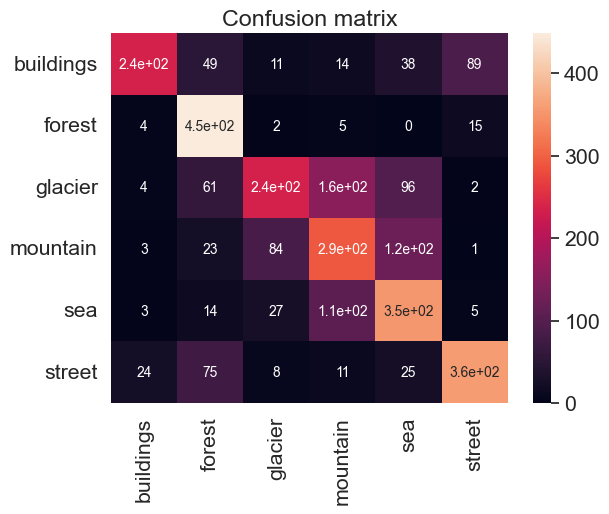

In [19]:
CM = metrics.confusion_matrix(y_test, y_pred)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=category_label, 
           yticklabels=category_label, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [35]:
print(metrics.classification_report(y_test, y_pred, target_names=category_label))

              precision    recall  f1-score   support

   buildings       0.86      0.54      0.66       437
      forest       0.67      0.95      0.78       474
     glacier       0.64      0.42      0.51       553
    mountain       0.50      0.55      0.52       525
         sea       0.56      0.69      0.62       510
      street       0.76      0.71      0.74       501

    accuracy                           0.64      3000
   macro avg       0.66      0.65      0.64      3000
weighted avg       0.66      0.64      0.63      3000



### 6. Visualization

#### Predict the category classification for some random image

In [21]:
def category_predict(img_path):
    image = cv2.imread(img_path)
    ip_image = Image.open(img_path)
    image = cv2.resize(image,(150,150))
    prd_image_data = extract_image_data(img_path)
    category_predicted = lsvc.predict(prd_image_data.reshape(1, -1))[0]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow(ip_image)
    ax[0].set_title('input image')

    ax[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    ax[1].set_title('category predicted :'+ category_label[category_predicted]);

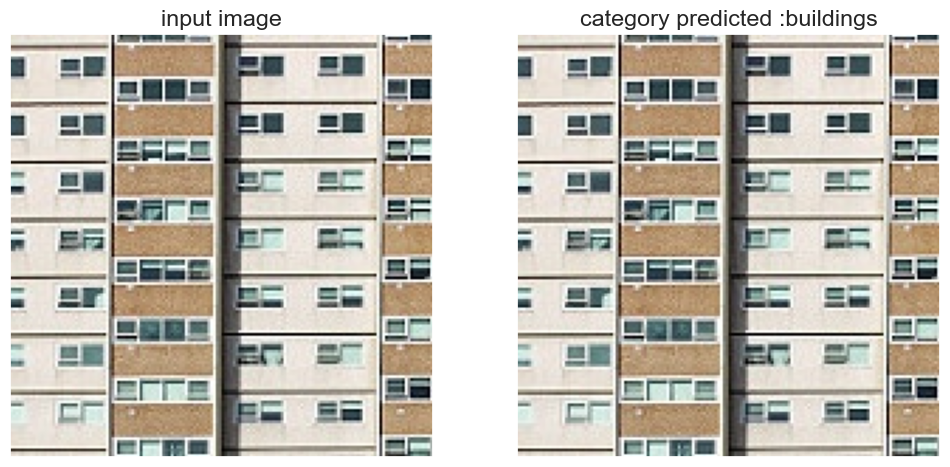

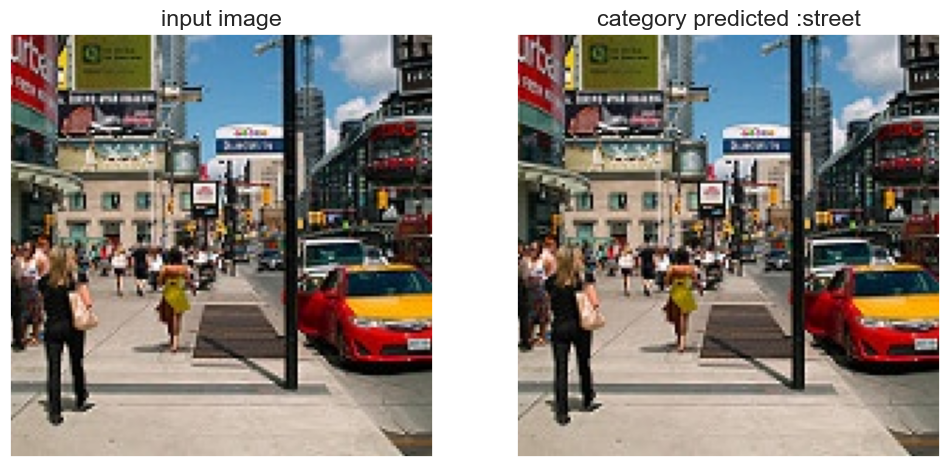

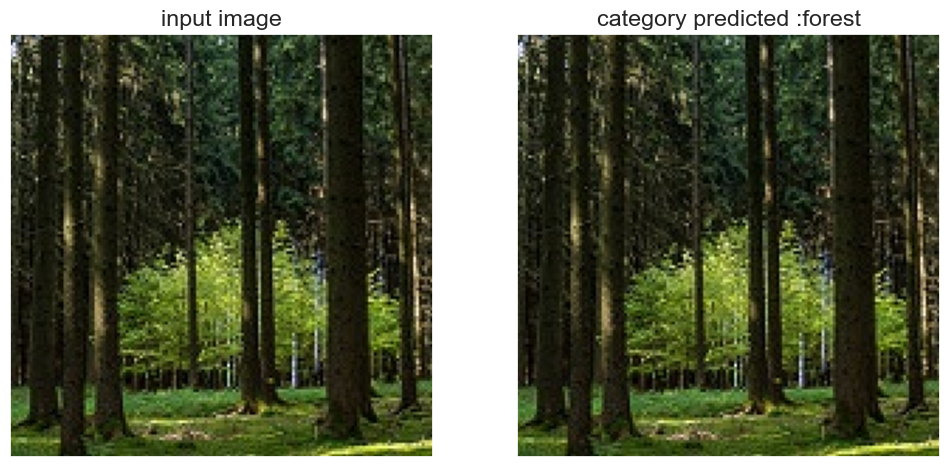

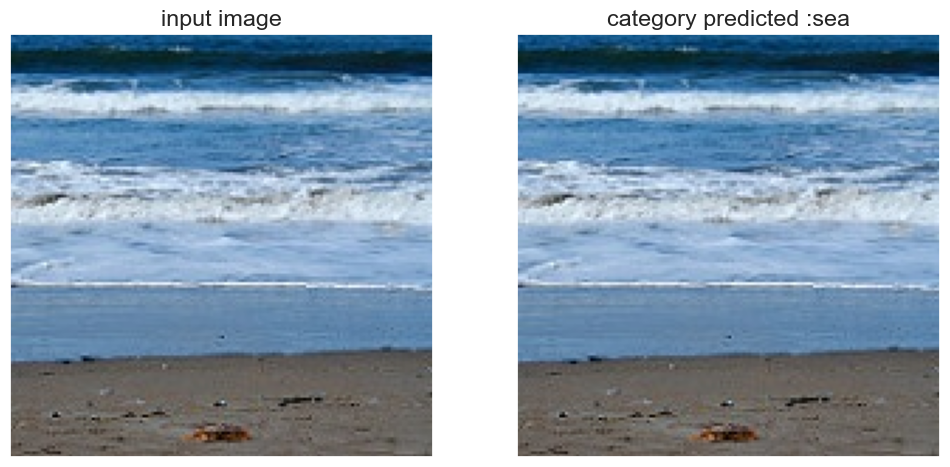

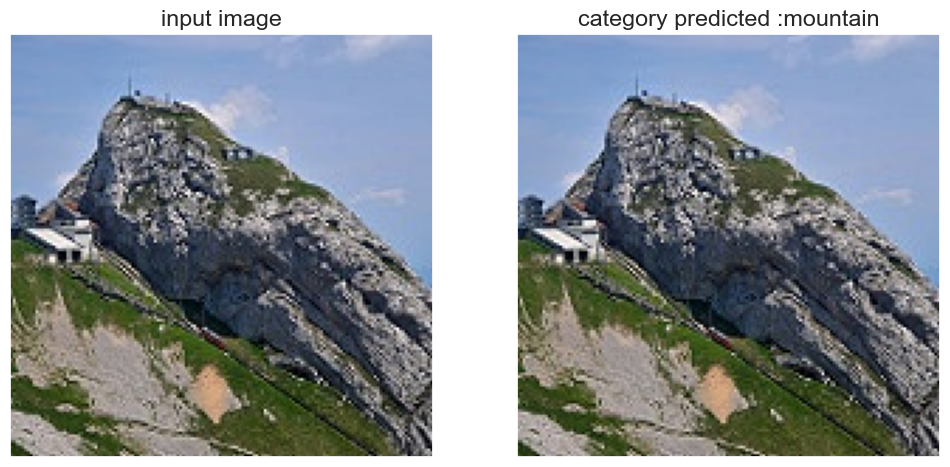

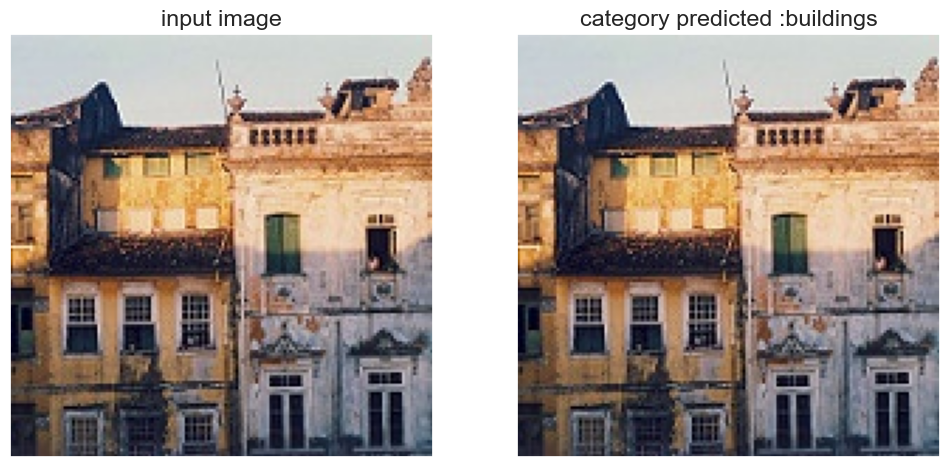

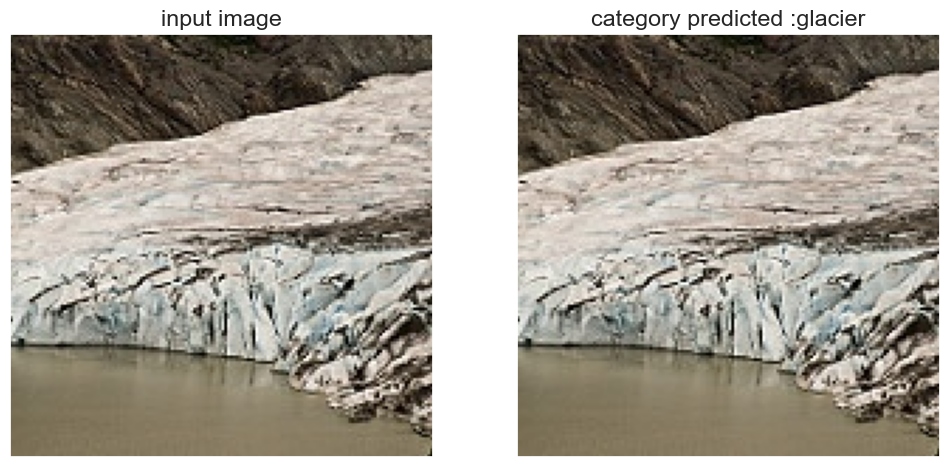

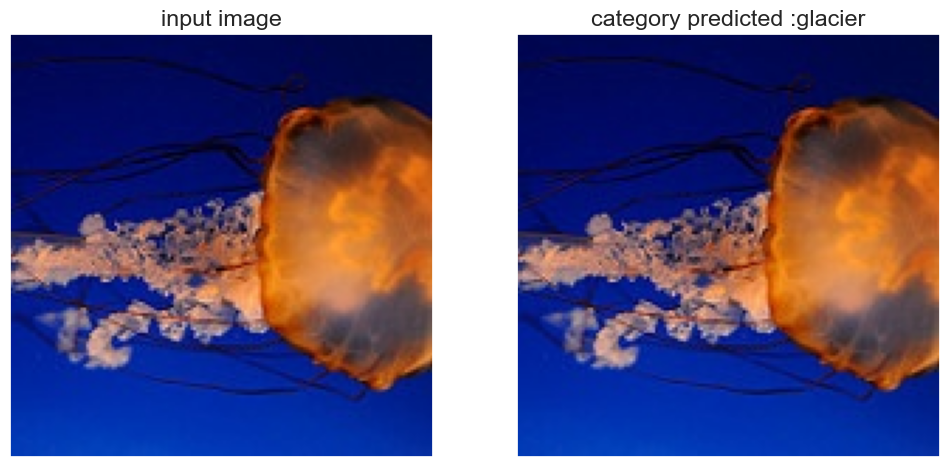

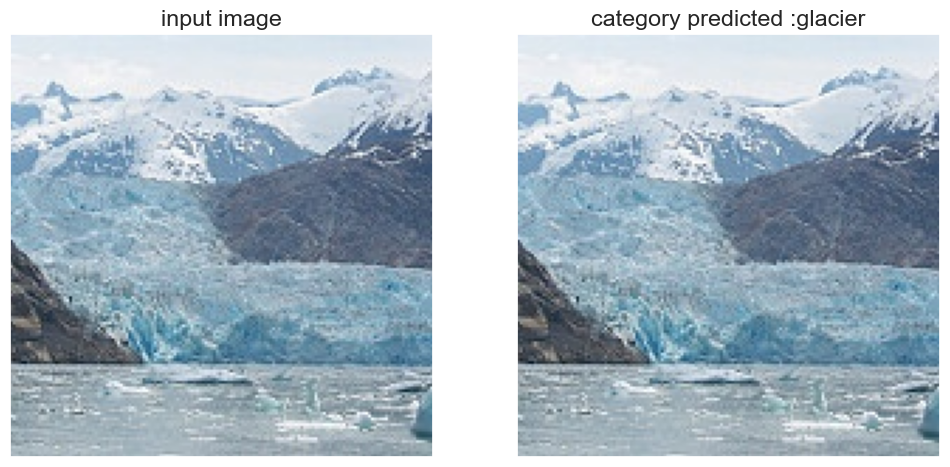

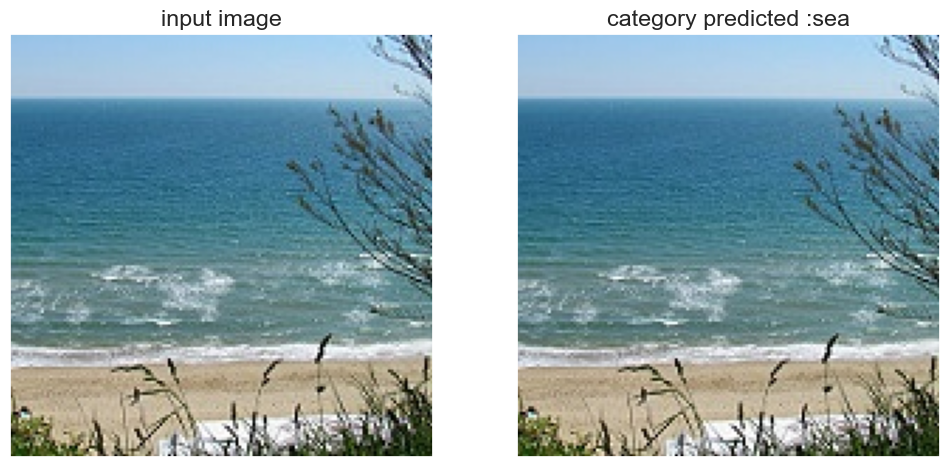

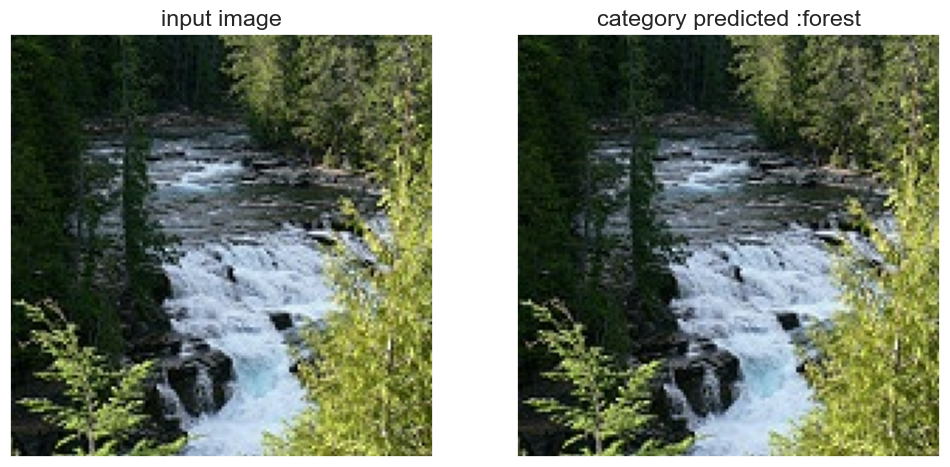

In [22]:
ip_img_folder = seg_pred_path
ip_img_files = ['222.jpg','121.jpg','88.jpg','398.jpg','839.jpg', '520.jpg', '38.jpg', '63.jpg', '101.jpg', '862.jpg', '890.jpg']
category_predicted = [category_predict(os.path.join(ip_img_folder,img_file))for img_file in ip_img_files]

In [23]:
seg_our_path = CURR_DIR_PATH + "//data//seg_our//seg_our"

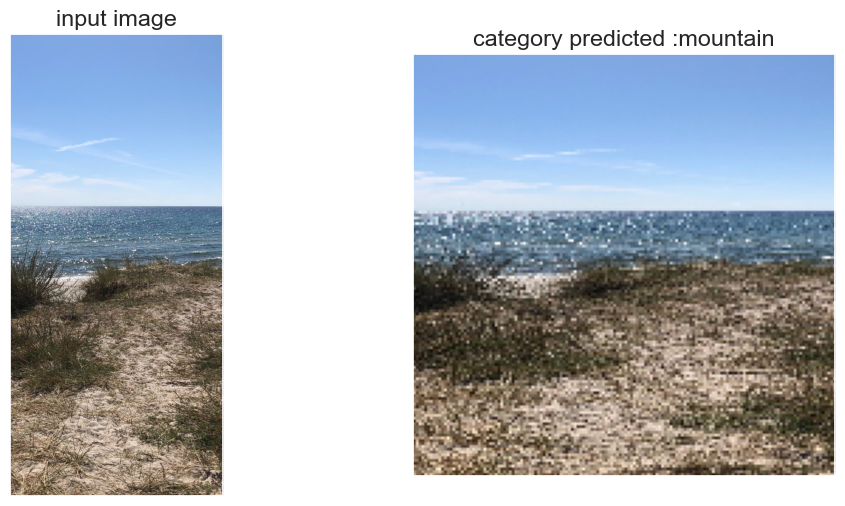

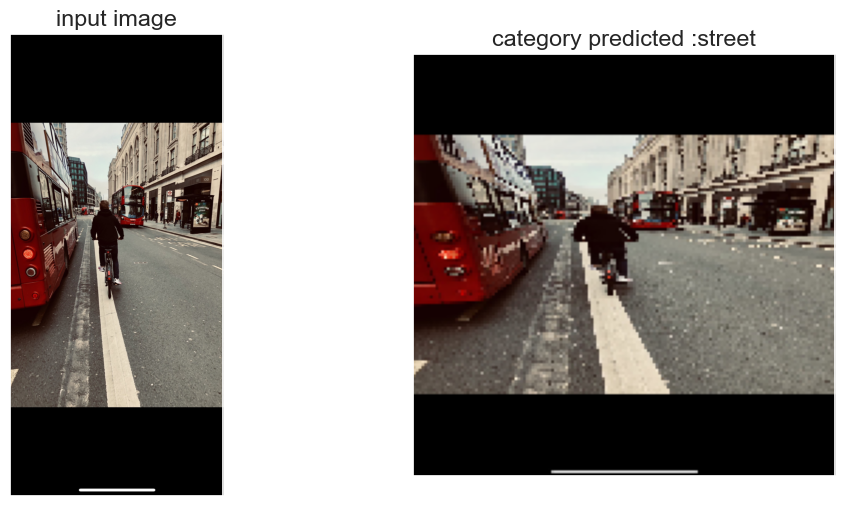

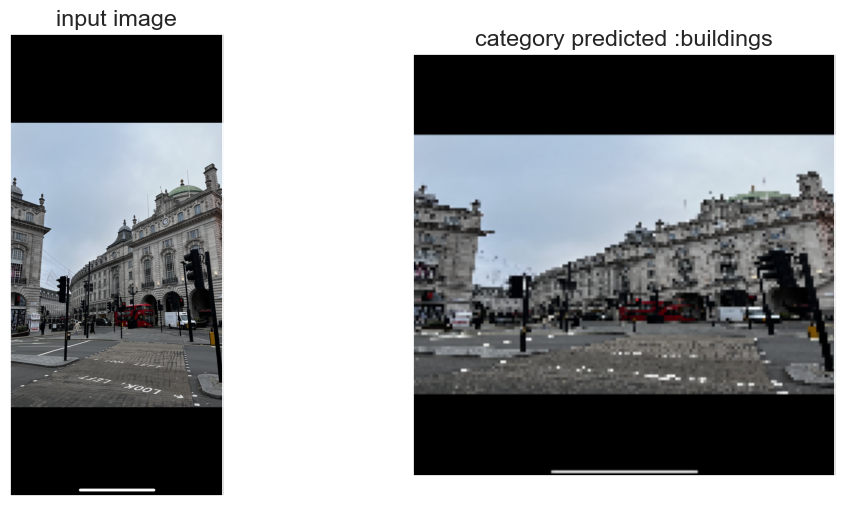

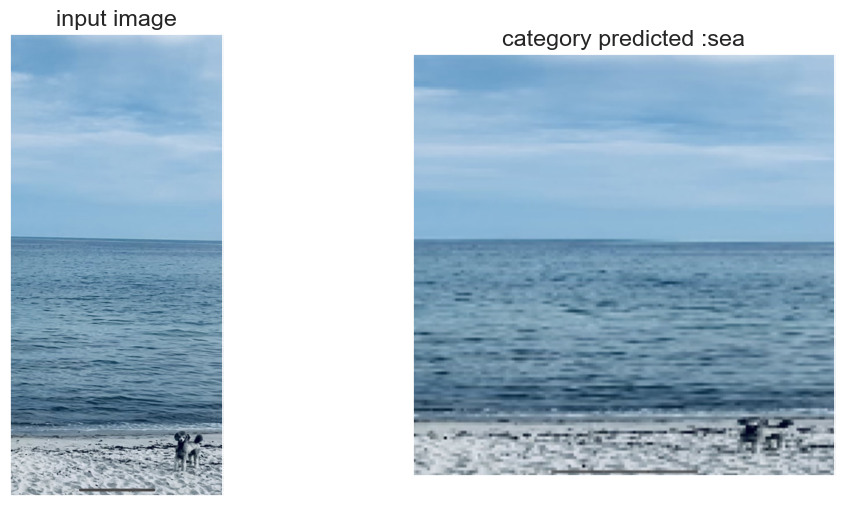

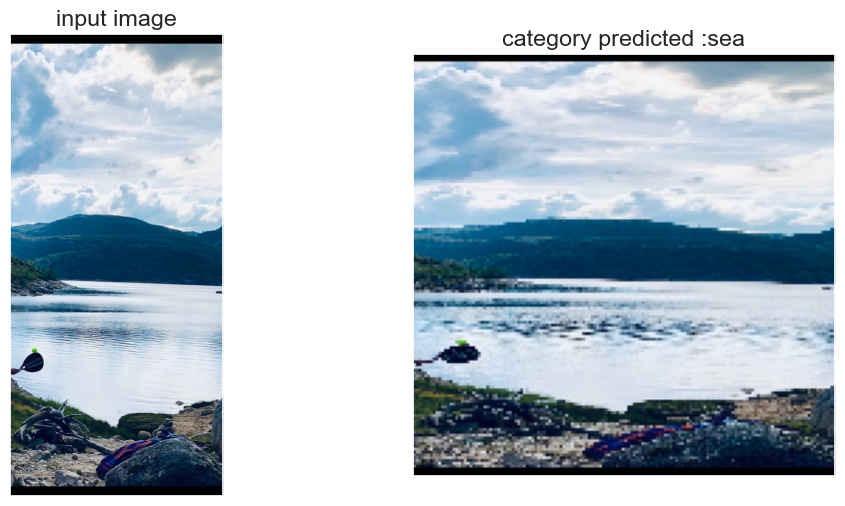

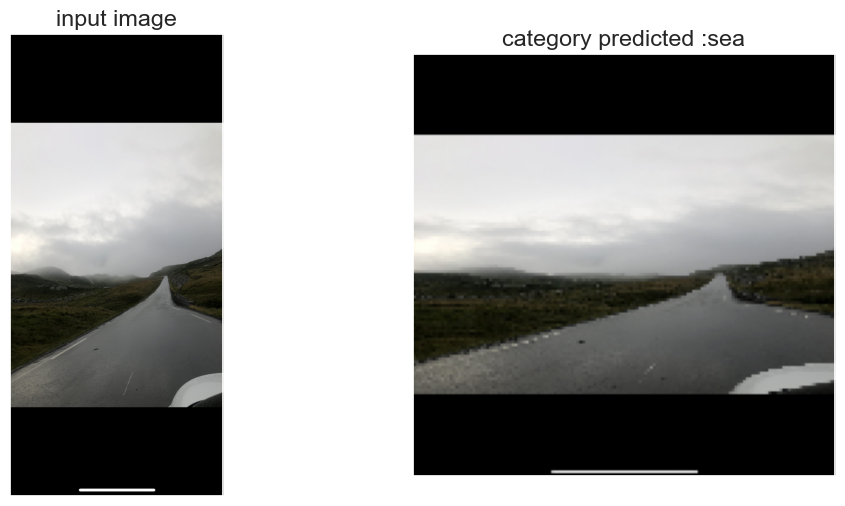

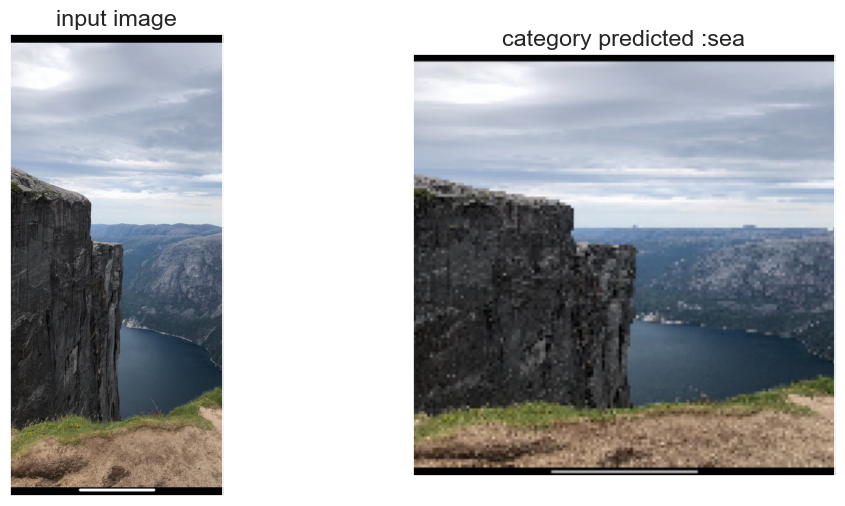

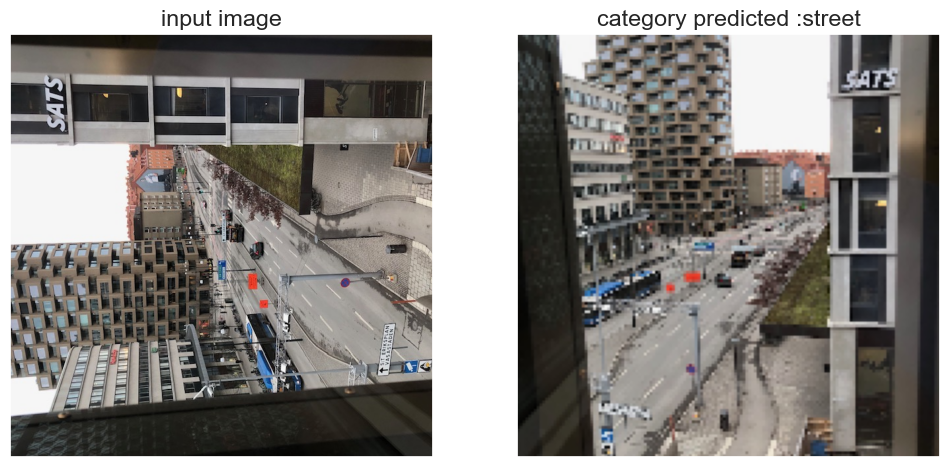

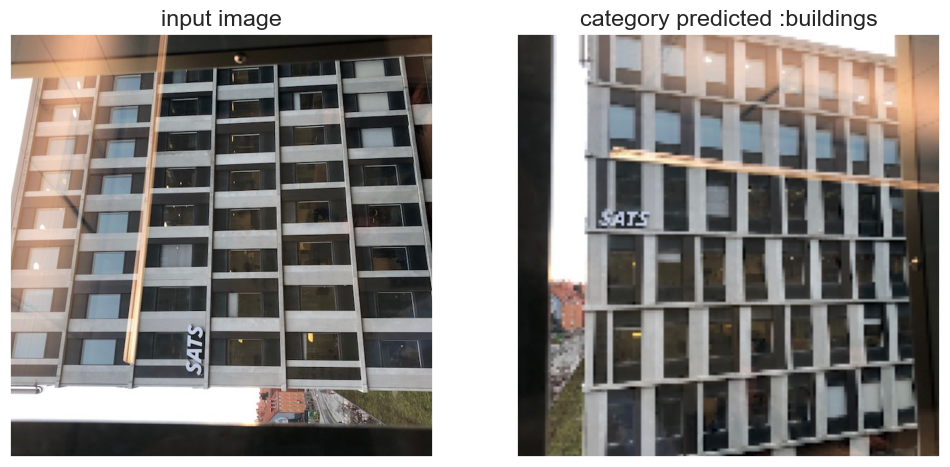

In [34]:
sebbe_list = ['1','2','3','4','5','6','7','8','9']
for number in sebbe_list:
    category_predict(seg_our_path + f"//sebbe{number}.jpg")